**qAIntum.ai**

# **Quantum Neural Network (QNN) 4-qumode MNIST Classifier Tutorial**

This note is an example of using Photonic Analog (PA) QNN for multi output classification. This is an application of the original work ["Continuous Variable Quantum MNIST Classifiers"](https://arxiv.org/abs/2204.01194). Classical and Continuous Variable Quantum hybrid network: Classical layers using keras dense and quantum layers using Pennylane's

Compared to Classical Neural Networks, PA QNNs have a reduced number of parameters to train and converge faster with fewer epochs. However, this is a quantum algorithm simulated on classical computers hence the training time for quantum circuits tend to be longer than classical models.

The dataset used in this example can be found https://yann.lecun.com/exdb/mnist/.

This file is organized in the following order:
0. Install and import necessary packages
1. Load and preprocess data 
2. Data encoding
3. QNN model
   * QNN layer
   * QNN circuit
   * Model building
4. Model training
5. Evaluation

For the open source repository, refer to https://github.com/qaintumai/quantum.

Dependencies: keras-nightly==2.5.0.dev2021032900 PennyLane==0.17.0 StrawberryFields==0.18.0 tensorflow-2.4.0-cp38-cp38-macosx_10_9_x86_64.whl

## 0. Importing necessary packages


In [1]:
!pip install keras-nightly==2.5.0.dev2021032900
!pip install PennyLane==0.17.0
!pip install StrawberryFields==0.19.0
!pip install tensorflow==2.4.0
!pip install torchsummary
!pip show pennylane


DEPRECATION: Loading egg at /Users/maxsivry/anaconda3/lib/python3.11/site-packages/fonttools-4.45.1-py3.11-macosx-10.9-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
DEPRECATION: Loading egg at /Users/maxsivry/anaconda3/lib/python3.11/site-packages/fonttools-4.45.1-py3.11-macosx-10.9-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached PennyLane-0.17.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached semantic_version-2.6.0-py3-none-any.whl.metadata (9.6 kB)
Using cached PennyLane-0.17.0-py3-none-any.whl (580 kB)
Using cached semantic_version-2.6.0-py3-none-any.wh

Using cached StrawberryFields-0.19.0-py3-none-any.whl (4.9 MB)
  Attempting uninstall: StrawberryFields
    Found existing installation: StrawberryFields 0.23.0
    Uninstalling StrawberryFields-0.23.0:
      Successfully uninstalled StrawberryFields-0.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pennylane-sf 0.29.1 requires pennylane<0.30,>=0.19, but you have pennylane 0.17.0 which is incompatible.
pennylane-sf 0.29.1 requires strawberryfields>=0.22, but you have strawberryfields 0.19.0 which is incompatible.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
DEPRECATION: Loading egg at /Users/maxsivry/anaconda3/lib/python3.11/site-packages/fonttools-4.45.1-py3.11-macosx-10.9-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package

In [2]:
!pip install strawberryfields
!pip install pennylane-sf

DEPRECATION: Loading egg at /Users/maxsivry/anaconda3/lib/python3.11/site-packages/fonttools-4.45.1-py3.11-macosx-10.9-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
DEPRECATION: Loading egg at /Users/maxsivry/anaconda3/lib/python3.11/site-packages/fonttools-4.45.1-py3.11-macosx-10.9-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached StrawberryFields-0.23.0-py3-none-any.whl.metadata (7.6 kB)
  Using cached PennyLane-0.29.1-py3-none-any.whl.metadata (8.7 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)


Using cached PennyLane-0.29.1-py3-none-any.whl (1.3 MB)
Using cached StrawberryFields-0.23.0-py3-none-any.whl (4.9 MB)
Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
  Attempting uninstall: semantic-version
    Found existing installation: semantic-version 2.6.0
    Uninstalling semantic-version-2.6.0:
      Successfully uninstalled semantic-version-2.6.0
  Attempting uninstall: strawberryfields
    Found existing installation: StrawberryFields 0.19.0
    Uninstalling StrawberryFields-0.19.0:
      Successfully uninstalled StrawberryFields-0.19.0
  Attempting uninstall: pennylane
    Found existing installation: PennyLane 0.17.0
    Uninstalling PennyLane-0.17.0:
      Successfully uninstalled PennyLane-0.17.0

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [20]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torchsummary import summary
import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt

## 0. Loading data and preprocessing

In [21]:
# Define a transform to convert PIL images to tensors and normalize the pixel values
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Convert images to tensors with pixel values in range [0, 1]
])

# Download and load the training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False)

# Download and load the test dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)

# Extract the full dataset from the DataLoader (this loads the entire dataset into memory)
X_train, Y_train = next(iter(trainloader))
X_test, Y_test = next(iter(testloader))

# Convert images to numpy arrays
X_train = X_train.numpy()
X_test = X_test.numpy()

# Convert labels to numpy arrays
Y_train = Y_train.numpy()
Y_test = Y_test.numpy()

# Print shapes to verify
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

# Verify that pixel values are in the range [0, 1]
print("X_train min and max values:", X_train.min(), X_train.max())
print("X_test min and max values:", X_test.min(), X_test.max())

X_train shape: (60000, 1, 28, 28)
Y_train shape: (60000,)
X_test shape: (10000, 1, 28, 28)
Y_test shape: (10000,)
X_train min and max values: 0.0 1.0
X_test min and max values: 0.0 1.0


In [22]:
def one_hot(labels):  
       
    depth =  2**4                       # 10 classes + 6 zeros for padding
    indices = labels.astype(np.int32)    
    one_hot_labels = np.eye(depth)[indices].astype(np.float32) 
    
    return one_hot_labels

# one-hot encoded labels, each label of length cutoff dimension**2
y_train, y_test = one_hot(Y_train), one_hot(Y_test)

# using only 600 samples for training in this experiment
n_samples = 600
test_samples = 100
X_train, X_test, y_train, y_test = X_train[:n_samples], X_test[:test_samples], y_train[:n_samples], y_test[:test_samples]

## 1. Classical circuit

Define classical layers using Keras Sequential. Take in 28x28 image matrices, flatten, and output vectors of length 30. 2 hidden layers with ELU activation.

In [23]:
model = nn.Sequential(
    nn.Flatten(),  # Flatten the input
    nn.Linear(28 * 28, 392),  # Dense layer with 392 units
    nn.ELU(),  # ELU activation function
    nn.Linear(392, 196),  # Dense layer with 196 units
    nn.ELU(),  # ELU activation function
    nn.Linear(196, 98),  # Dense layer with 98 units
    nn.Linear(98, 49),  # Dense layer with 49 units
    nn.ELU(),  # ELU activation function
    nn.Linear(49, 30)  # Dense layer with 30 units
)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 392]         307,720
               ELU-3                  [-1, 392]               0
            Linear-4                  [-1, 196]          77,028
               ELU-5                  [-1, 196]               0
            Linear-6                   [-1, 98]          19,306
            Linear-7                   [-1, 49]           4,851
               ELU-8                   [-1, 49]               0
            Linear-9                   [-1, 30]           1,500
Total params: 410,405
Trainable params: 410,405
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.57
Estimated Total Size (MB): 1.59
-------------------------------------------

## 2. Data encoding circuit

Encode the output vectors from the classical network into quantum states using the vector entries as parameters of continuous variable gates. 

In [24]:
def data_encoding(x):
    """
    This function converts classical data into a quantum state by using the data entries as parameters of the quantum gates.
    Input: classical data (x)
    No output: quantum state prepared to be operated on by the quantum layers
    """
    num_features = len(x)
    num_wires = 4 
    # NOTE: although num_wires can be passed as an argument in building quantum circuits in pennylane, the circuit function 
    # takes only two arguments: data and intitialized weights
    
    print("EPOCH")
    
    # Squeezing gates
    for i in range(0, min(num_features, num_wires * 2), 2):
        print("squeeze")
        qml.Squeezing(x[i], x[i + 1], wires=i // 2)

    # Beamsplitter gates
    for i in range(num_wires - 1):
        idx = num_wires * 2 + i * 2
        print("beam")
        if idx + 1 < num_features:
            qml.Beamsplitter(x[idx], x[idx + 1], wires=[i % num_wires, (i + 1) % num_wires])

    # Rotation gates
    for i in range(num_wires):
        print("rotate")
        idx = num_wires * 2 + (num_wires - 1) * 2 + i
        if idx < num_features:
            qml.Rotation(x[idx], wires=i)

    # Displacement gates
    for i in range(num_wires):
        print("displace")
        idx = num_wires * 2 + (num_wires - 1) * 2 + num_wires + i * 2
        if idx + 1 < num_features:
            qml.Displacement(x[idx], x[idx + 1], wires=i)

    # Kerr gates
    for i in range(num_wires):
        print("kerr")
        idx = num_wires * 2 + (num_wires - 1) * 2 + num_wires + num_wires * 2 + i
        if idx < num_features:
            qml.Kerr(x[idx], wires=i)

    # Squeezing gates (second set)

    for i in range(0, min(num_features - (num_wires * 2 + (num_wires - 1) * 2 + num_wires + num_wires * 2 + num_wires), num_wires * 2), 2):
        print("squeeze2")
        idx = num_wires * 2 + (num_wires - 1) * 2 + num_wires + num_wires * 2 + num_wires + i
        if idx + 1 < num_features:
            qml.Squeezing(x[idx], x[idx + 1], wires=i // 2)

    # Rotation gates (second set)
    for i in range(num_wires):
        print("rotate2")
        idx = num_wires * 2 + (num_wires - 1) * 2 + num_wires + num_wires * 2 + num_wires + num_wires * 2 + i
        if idx < num_features:
            qml.Rotation(x[idx], wires=i)

## 3. Qauntum neural network circuit

In [25]:
def qnn_layer(v):
    """
    This is one layer of QNN
    Input: quantum parameters (v)
    No output: quantum state prepared to be measured
    """
    num_params = len(v)
    num_wires = 4

    # Interferometer 1
    for i in range(num_wires - 1):
        idx = i * 2
        print("Interfermoter")
        if idx + 1 < num_params:
            theta = v[idx]
            phi = v[idx + 1]
            qml.Beamsplitter(theta, phi, wires=[i % num_wires, (i + 1) % num_wires])
            print("InterBeam")
            

    for i in range(num_wires):
        idx = (num_wires - 1) * 2 + i
        if idx < num_params:
            qml.Rotation(v[idx], wires=i)
            print("layer3")

    # Squeezers
    for i in range(num_wires):
        idx = (num_wires - 1) * 2 + num_wires + i
        print("layer4")
        if idx < num_params:
            qml.Squeezing(v[idx], 0.0, wires=i)
            print("layer5")

    # Interferometer 2
    for i in range(num_wires - 1):
        idx = (num_wires - 1) * 2 + num_wires + num_wires + i * 2
        print("layer8")
        if idx + 1 < num_params:
            theta = v[idx]
            phi = v[idx + 1]
            qml.Beamsplitter(theta, phi, wires=[i % num_wires, (i + 1) % num_wires])
            print("layer7")

    for i in range(num_wires):
        print("layer9")
        idx = (num_wires - 1) * 2 + num_wires + num_wires + (num_wires - 1) * 2 + i
        if idx < num_params:
            qml.Rotation(v[idx], wires=i)
            print("layer10")

    # Bias addition
    for i in range(num_wires):
        print("layer11")
        idx = (num_wires - 1) * 2 + num_wires + num_wires + (num_wires - 1) * 2 + num_wires + i
        if idx < num_params:
            qml.Displacement(v[idx], 0.0, wires=i)
            print("layer12")

    # Non-linear activation function
    for i in range(num_wires):
        print("layer13")
        idx = (num_wires - 1) * 2 + num_wires + num_wires + (num_wires - 1) * 2 + num_wires + num_wires + i
        if idx < num_params:
            print("layer14")
            qml.Kerr(v[idx], wires=i)

## 4. Quantum device

For the expression of qumodes in Fock basis, choose a "strawberryfields.fock" device. Define the number of qumodes and cutoff dimension. Run the data encoding circuit and quantum neural network circuit. The probability measurement method (qml.probs(wires)) returns vectors of size 2^4 = 16 (cutoff_dim^num_modes).

In [26]:
num_modes = 4
cutoff_dim = 2

# select a devide 
dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=cutoff_dim) 

@qml.qnode(dev, interface="torch")
def quantum_nn(inputs, var):
    # Encode input x into quantum state
    data_encoding(inputs)

    # iterative quantum layers
    for v in var:
        qnn_layer(v)

    return qml.probs(wires=[0, 1, 2, 3])  # Measurement

## 5. Hybrid circuit

In [27]:
weight_shape = {'var': (4,32)}          # 4 layers and 32 parameters per layer, Keras layer will initialize.

# Define the quantum layer using TorchLayer
quantum_layer = qml.qnn.TorchLayer(quantum_nn, weight_shape)
# add to the classical sequential model
model.add_module('quantum_layer', quantum_layer)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=392, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=392, out_features=196, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=196, out_features=98, bias=True)
  (6): Linear(in_features=98, out_features=49, bias=True)
  (7): ELU(alpha=1.0)
  (8): Linear(in_features=49, out_features=30, bias=True)
  (quantum_layer): <Quantum Torch Layer: func=quantum_nn>
)


## 6. Loss function and optimizer

In [28]:
# Define the learning rate
lr = 0.02

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)

# Define the loss function
criterion = nn.CrossEntropyLoss()


## 7. Training

In [29]:
epochs = 3
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"Starting epoch {epoch+1}")
    for inputs, labels in trainloader:
        print("Loading batch")
        inputs = inputs.view(inputs.size(0), -1)
        print("Reshaping inputs")
        
        optimizer.zero_grad()
        print("Zeroing gradients")
        
        outputs = model(inputs)
        print("Forward pass")
        
        loss = criterion(outputs, labels)
        print("Calculating loss")
        
        loss.backward()
        print("Backward pass")
        
        optimizer.step()
        print("Updating weights")

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    print("Starting validation")
    with torch.no_grad():
        for val_inputs, val_labels in testloader:
            print("Loading validation batch")
            val_outputs = model(val_inputs)
            print("Validation forward pass")
            
            val_loss += criterion(val_outputs, val_labels).item()
            print("Calculating validation loss")
            
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_loss /= len(testloader)
    val_acc = 100 * val_correct / val_total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")


Starting epoch 1
Loading batch
Reshaping inputs
Zeroing gradients
EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
l

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
lay

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
l

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10


EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10


EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
lay

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
Inter

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
lay

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

EPOCH
squeeze
squeeze
squeeze
squeeze
beam
beam
beam
rotate
rotate
rotate
rotate
displace
displace
displace
displace
kerr
kerr
kerr
kerr
rotate2
rotate2
rotate2
rotate2
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermoter
InterBeam
layer3
layer3
layer3
layer3
layer4
layer5
layer4
layer5
layer4
layer5
layer4
layer5
layer8
layer7
layer8
layer7
layer8
layer7
layer9
layer10
layer9
layer10
layer9
layer10
layer9
layer10
layer11
layer12
layer11
layer12
layer11
layer12
layer11
layer12
layer13
layer14
layer13
layer14
layer13
layer14
layer13
layer14
Interfermoter
InterBeam
Interfermoter
InterBeam
Interfermot

KeyboardInterrupt: 

In [ ]:
import torch.nn as nn
import time

class DebugSequential(nn.Sequential):
    def forward(self, input):
        for idx, module in enumerate(self._modules.values()):
            start_time = time.time()
            input = module(input)
            end_time = time.time()
            print(f"Layer {idx}: {module.__class__.__name__} took {end_time - start_time:.6f} seconds")
        return input

# Define the classical part of the model
model = DebugSequential(
    nn.Flatten(),  # Flatten the input
    nn.Linear(28 * 28, 392),  # Dense layer with 392 units
    nn.ELU(),  # ELU activation function
    nn.Linear(392, 196),  # Dense layer with 196 units
    nn.ELU(),  # ELU activation function
    nn.Linear(196, 98),  # Dense layer with 98 units
    nn.Linear(98, 49),  # Dense layer with 49 units
    nn.ELU(),  # ELU activation function
    nn.Linear(49, 30)  # Dense layer with 30 units
)

# Define the quantum layer using TorchLayer
quantum_layer = qml.qnn.TorchLayer(quantum_nn, weight_shape)

# Add the quantum layer to the classical sequential model
model.add_module('quantum_layer', quantum_layer)

print(model)

epochs = 3
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"Starting epoch {epoch+1}")
    for inputs, labels in trainloader:
        print("Loading batch")
        inputs = inputs.view(inputs.size(0), -1)
        print("Reshaping inputs")
        
        optimizer.zero_grad()
        print("Zeroing gradients")
        
        outputs = model(inputs)
        print("Forward pass")
        
        loss = criterion(outputs, labels)
        print("Calculating loss")
        
        loss.backward()
        print("Backward pass")
        
        optimizer.step()
        print("Updating weights")

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    print("Starting validation")
    with torch.no_grad():
        for val_inputs, val_labels in testloader:
            print("Loading validation batch")
            val_inputs = val_inputs.view(val_inputs.size(0), -1)
            print("Reshaping validation inputs")
            val_outputs = model(val_inputs)
            print("Validation forward pass")
            
            val_loss += criterion(val_outputs, val_labels).item()
            print("Calculating validation loss")
            
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_loss /= len(testloader)
    val_acc = 100 * val_correct / val_total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")


In [34]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 392)            │       307,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 196)            │        77,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 49)             │         4,851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 30)             │         1,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 410,405 (1.57 MB)

 Trainable params: 410,405 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

## 8. Loss and accuracy graphs

NameError: name 'hybrid' is not defined

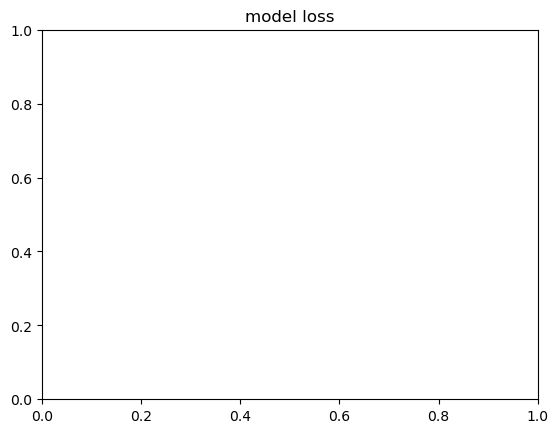

In [44]:
# ===================================================================================
#                                  Loss History Plot
# ===================================================================================

plt.title('model loss')
plt.plot(hybrid.history['loss'], '-g')
plt.ylabel('loss')
plt.show()

NameError: name 'hybrid' is not defined

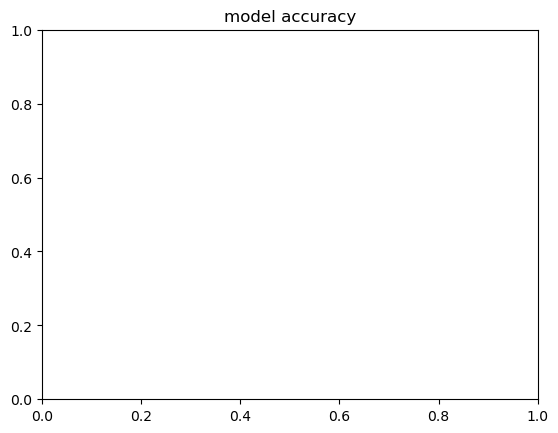

In [45]:
# ===================================================================================
#                                Accuracy History Plot
# ===================================================================================

plt.title('model accuracy')
plt.plot(hybrid.history['accuracy'], '-g')
plt.ylabel('accuracy')
plt.show()